In [1]:
# !pip install torch==1.9.0+cu111 torchvision==0.10.0+cu111 torchaudio==0.9.0 -f https://download.pytorch.org/whl/torch_stable.html

In [2]:
# !pip install transformers

In [3]:
# !pip install datasets

In [4]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers

In [5]:
torch.__version__

'1.9.0+cu111'

In [6]:
df = pd.read_csv('../data/amazon_large_stratified.csv', index_col=0)

In [7]:
df['review_sentiments'].value_counts()

1    500000
0    500000
Name: review_sentiments, dtype: int64

In [8]:
train_texts, temp_texts, train_labels, temp_labels = train_test_split(df['review'].tolist(), 
                                                                      df['review_sentiments'].tolist(), 
                                                                      stratify=df['review_sentiments'].tolist(), 
                                                                      test_size=0.5, 
                                                                      random_state=42)

In [9]:
val_texts, test_texts, val_labels, test_labels = train_test_split(temp_texts, 
                                                                  temp_labels, 
                                                                  stratify=temp_labels, 
                                                                  test_size=250000, 
                                                                  random_state=42)

In [10]:
df.head()

,review,review_sentiments
3837169,Disappointing treatment of a great album. This...,0
2882480,Good read. I have read all the books in this s...,1
4587996,"NOPE.. Just my opinion obviously, but every ti...",0
196423,"Passing gas was the highlight, and I HATED th...",0
94421,not believable **SPOILERS**. I really like his...,0


In [11]:
print(len(train_texts), len(val_texts), len(test_texts))

500000 250000 250000


In [12]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

In [13]:
seq_len = [len(i.split()) for i in train_texts]

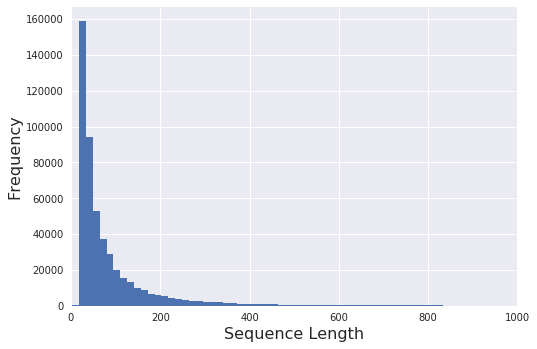

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')

pd.Series(seq_len).hist(bins = 500)
plt.xlim((0, 1000))
plt.xlabel('Sequence Length', fontsize=16)
plt.ylabel('Frequency', fontsize=16)
plt.show()

In [15]:
train_encodings = tokenizer(train_texts, truncation=True, 
                            padding=True, max_length = 200)
val_encodings = tokenizer(val_texts, truncation=True, 
                          padding=True, max_length = 200)
test_encodings = tokenizer(test_texts, truncation=True, 
                           padding=True, max_length = 200)

In [16]:
class AmazonReviewsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = AmazonReviewsDataset(train_encodings, train_labels)
val_dataset = AmazonReviewsDataset(val_encodings, val_labels)
test_dataset = AmazonReviewsDataset(test_encodings, test_labels)

In [17]:
print(len(train_labels), len(val_labels), len(test_labels))

500000 250000 250000


In [18]:
from transformers import AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.weight', 'classifi

In [19]:
model

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
       

In [20]:
# freeze all pretrained parameter
for param in model.distilbert.parameters():
    param.requires_grad = False

In [21]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=3,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    save_strategy="epoch", 
    evaluation_strategy="epoch", 
    load_best_model_at_end=True
)

In [22]:
from datasets import load_metric

metric = load_metric("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [23]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()

***** Running training *****
  Num examples = 500000
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 93750


Epoch,Training Loss,Validation Loss


In [25]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 250000
  Batch size = 64


{'eval_loss': 0.31976914405822754,
 'eval_f1': 0.8660204550723156,
 'eval_runtime': 3631.8424,
 'eval_samples_per_second': 68.836,
 'eval_steps_per_second': 1.076,
 'epoch': 3.0}